<a href="https://www.kaggle.com/code/rmeades/auto-feature-selection-in-house-price-predictions?scriptVersionId=118886873" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# INTRODUCTION

The following code demonstrates a mehtod of auto feature selection using the SULOV method (Searching for Uncorrelated List of Variables) and recursive XGBoost feature selection as implemented in FeatureWiz. I was curious to see how this would perform in the competition vs manual methods. Trained model is an XGBoost regressor with early stopping to avoid overfitting.

This resulted in a leaderboard score of 0.14679 (RMSE). By comparison, my other, rather simple attempt wihtout Featurewiz scored 0.17127 (RMSE), see notebook here https://www.kaggle.com/code/rmeades/ames-house-price-predictions?kernelSessionId=118579471

Without further ado, let's crack on and load the preliminaries.............

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
!pip install featurewiz -q
!pip install featurewiz --upgrade --quiet
from featurewiz import featurewiz as FW
from sklearn.model_selection import cross_val_score,train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have j

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# DATA PREPROCESSING
Let's read in the train and test datasets into dataframes using pandas and take a look at a summary of what they consist of...

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

<AxesSubplot:>

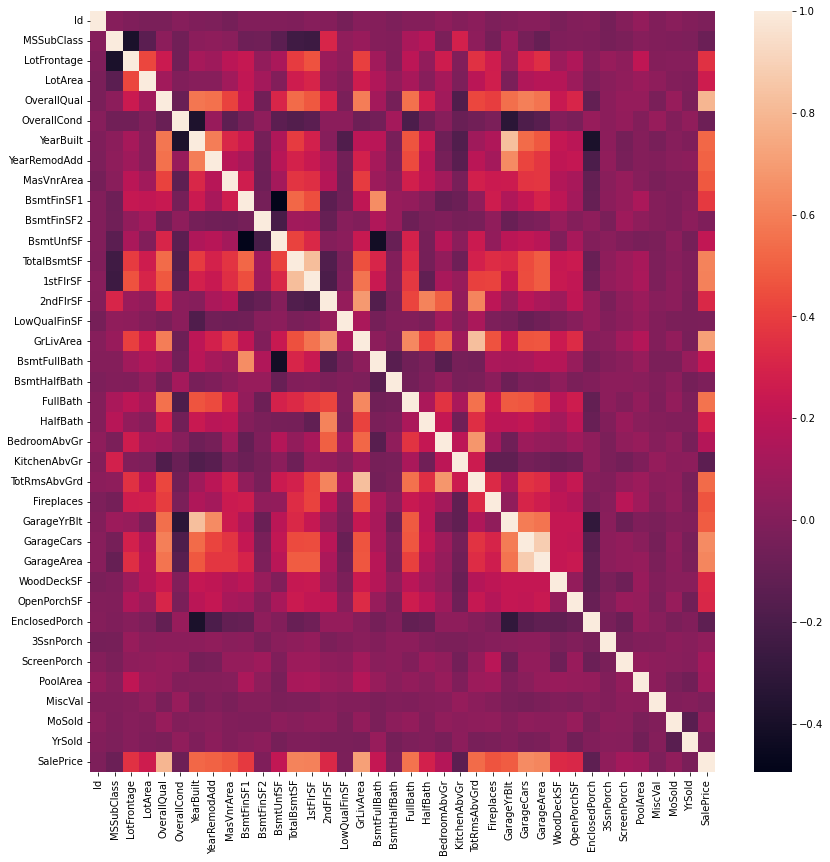

In [5]:
plt.figure(figsize=(14, 14))
sns.heatmap(train.corr())

Now let's use featurewiz to select the independant variables that are most useful. I have set the correlation limit to 0.8 (default 0.7). THis is the value above which pairs of intercorrelated variables are chosen for one of them to be removed (the one with the lowest mutual information score with respects to the target variable).

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (1460, 81)
#### Single_Label Regression problem ####
loading the entire test dataframe - there is no nrows limit applicable #########
    Loaded test data. Shape = (1459, 80)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E

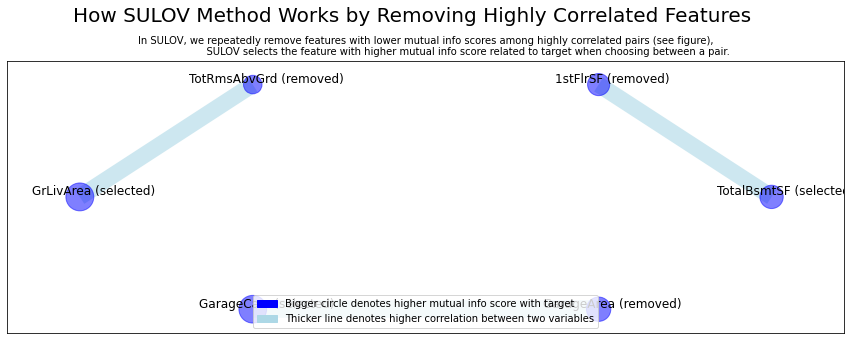

Time taken for SULOV method = 0 seconds
    Adding 40 categorical variables to reduced numeric variables  of 31
Finally 71 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (1460, 75)
    Shape of test data after adding missing values flags  = (1459, 74)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 74 
    Taking top 11 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 74 variables...
            selecting 34 features in this iteration

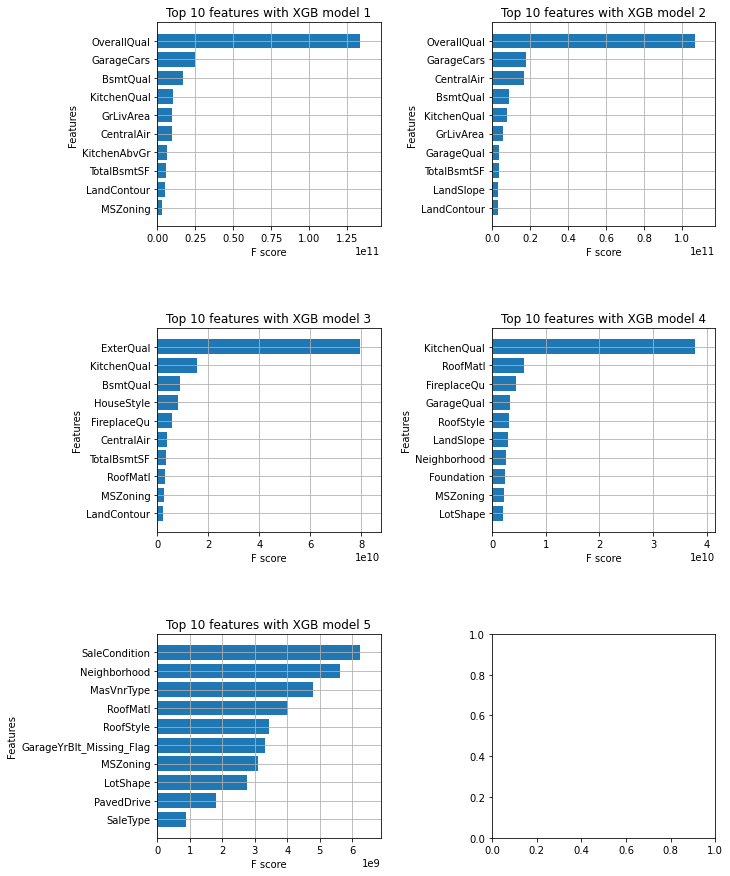

    Completed XGBoost feature selection in 1 seconds
    Alert: No ID variables ['Id'] are included in selected features
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Alert: Dont forget to add a missing flag to GarageYrBlt to create GarageYrBlt_Missing_Flag column
Selected 45 important features. Too many to print...
Total Time taken for featurewiz selection = 4 seconds
Output contains two dataframes: train and test with 45 important features.
There are special chars in column names. Please remove them and try again.


In [6]:
train_select, test_select = FW(train, "SalePrice", corr_limit=0.8, test_data=test, category_encoders="", verbose=2)

It has reduced he number of features from 80 to 45! Let's see what it has selected.......

In [7]:
train_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1460 non-null   int64  
 1   GarageCars     1460 non-null   int64  
 2   BsmtQual       1460 non-null   int64  
 3   KitchenQual    1460 non-null   int64  
 4   GrLivArea      1460 non-null   int64  
 5   CentralAir     1460 non-null   int64  
 6   KitchenAbvGr   1460 non-null   int64  
 7   TotalBsmtSF    1460 non-null   int64  
 8   LandContour    1460 non-null   int64  
 9   MSZoning       1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  GarageType     1460 non-null   int64  
 12  ExterQual      1460 non-null   int64  
 13  BsmtFinSF1     1460 non-null   int64  
 14  BsmtFullBath   1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  LotShape       1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  Fireplac

<AxesSubplot:>

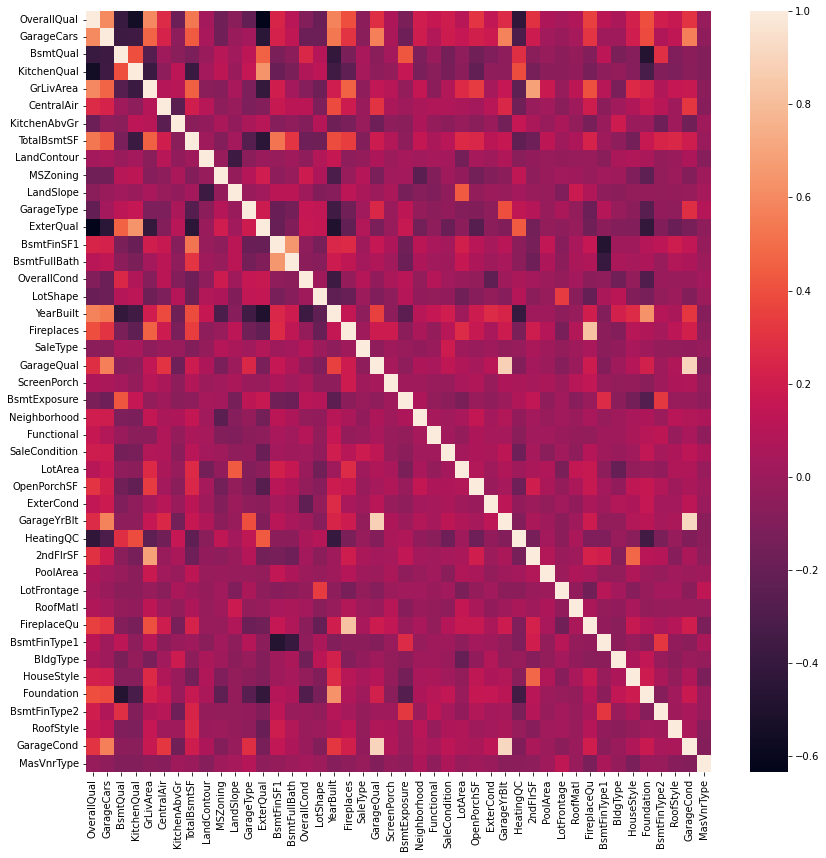

In [8]:
plt.figure(figsize=(14, 14))
sns.heatmap(train_select.corr())

OK. Not only has it selected the variables correlated the most with SalePrice whilst eliminateinghighly correlated features, it has also encoded the catagorical variables (no 'object' data types) and handled all the missing values.

In [9]:
y = train["SalePrice"]

# MODEL TRAINING

Now let's see how the XGBoost algorithm performs in cross validation on th train data using these selected features

In [10]:
XGB_model = XGBRegressor(random_state=0)

XGB_scores = cross_val_score(XGB_model, train_select, y, cv=5, scoring="neg_root_mean_squared_error")
XGB_mean_score = XGB_scores.mean()
XGB_std_score = XGB_scores.std()
print(f"RMSE = {XGB_scores}")
print(f"Mean RMSE = {XGB_mean_score:.2f}")
print(f"StDev RMSE = {XGB_std_score:.2f}")

RMSE = [-25086.06099952 -29543.51174365 -30713.55650129 -22579.69447158
 -26015.87980741]
Mean RMSE = -26787.74
StDev RMSE = 2973.40


Now we'll take a look at if it is overfitting and implement early stopping to prevent this

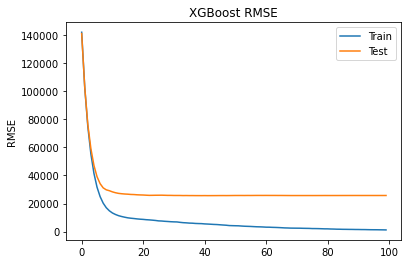

In [11]:
XGB_model = XGBRegressor(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(train_select, y, test_size=0.33, random_state=0)

eval_set = [(X_train, y_train), (X_test, y_test)]
XGB_model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
results = XGB_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [12]:
eval_set = [(X_test, y_test)]
XGB_model.fit(X_train, y_train, early_stopping_rounds=8, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:140822.18553
[1]	validation_0-rmse:102605.21330
[2]	validation_0-rmse:76203.49455
[3]	validation_0-rmse:58998.03690
[4]	validation_0-rmse:47012.50365
[5]	validation_0-rmse:39038.60664
[6]	validation_0-rmse:34109.19874
[7]	validation_0-rmse:31122.09514
[8]	validation_0-rmse:29728.21186
[9]	validation_0-rmse:29105.96574
[10]	validation_0-rmse:28278.19426
[11]	validation_0-rmse:27658.83478
[12]	validation_0-rmse:27206.35026
[13]	validation_0-rmse:26952.50543
[14]	validation_0-rmse:26752.16143
[15]	validation_0-rmse:26629.41299
[16]	validation_0-rmse:26439.09214
[17]	validation_0-rmse:26370.39746
[18]	validation_0-rmse:26202.04222
[19]	validation_0-rmse:26102.80248
[20]	validation_0-rmse:26035.20202
[21]	validation_0-rmse:25902.75381
[22]	validation_0-rmse:25797.59157
[23]	validation_0-rmse:25826.65370
[24]	validation_0-rmse:25871.07234
[25]	validation_0-rmse:25885.80542
[26]	validation_0-rmse:25912.22453
[27]	validation_0-rmse:25852.94348
[28]	validation_0-rmse:25781

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# PREDICTIONS AND OUTPUT

Finally we'll make predictons on the test data using this trained model

In [13]:
test_pred = XGB_model.predict(test_select)
pred = pd.concat([test["Id"],pd.Series(test_pred,name='SalePrice')],axis=1)
pred['Id'] = pred['Id'].astype('int')
pred.to_csv('/kaggle/working/submission.csv', index=False)